In [1]:
from qiskit_algorithms import VarQITE, TimeEvolutionProblem
from qiskit_algorithms.gradients import LinCombEstimatorGradient, LinCombQGT
import qiskit_algorithms.utils as utils
import qiskit_algorithms.time_evolvers.variational.variational_principles.imaginary_mc_lachlan_principle as mc_lachlan

In [2]:
mc_lachlan.idiot_function() # This is a test function to see if the homemade code is imported correctly

Idiot function


In [3]:
# Other imports

from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import ParityMapper

In [4]:
# Hamiltonian
data = np.loadtxt('qubit_hamil_h2.txt', dtype=str)
paulistrings = data[:,0] 
coefficients = (data[:,1])
coefficients = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
#print(paulis)
qubit_op = SparsePauliOp.from_list(paulis)

print(f"Number of qubits: {qubit_op.num_qubits}")
#print(qubit_op)

Number of qubits: 2


In [5]:
# Ansatz
nreps = 1

#initial_point = hf_params_h2o_jw(nreps=nreps, perturb=0.00)
#print(initial_point)

ansatz = EfficientSU2(qubit_op.num_qubits, reps=nreps)

init_param_values = {}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = np.pi / 2
#print(init_param_values)

# UCCSD instead
#ansatz = UCCSD(num_spatial_orbitals=8, num_particles=[2,2], qubit_mapper=ParityMapper())
#hf_initial_point = HFInitialPoint()
#hf_initial_point.ansatz = ansatz
#init_param_values = hf_initial_point.to_numpy_array()
#print(init_param_values)

#ansatz.decompose().draw("mpl", style="iqx")

In [6]:
# Estimator
seed = 170
estimator = Estimator(options={'seed': seed})

In [7]:
###############
### VarQITE ###
###############

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = mc_lachlan.ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result = qite.evolve(time_evo)

QGT:
anti-hermitian in run:  False
ok this is unique we want to build this
anti_hermitian in make_grad_circ: False
H plus:
anti-hermitian in run:  False
ok this is unique we want to build this
anti_hermitian in make_grad_circ: False
H minus:
anti-hermitian in run:  True
we have this circuit at home
QGT:
anti-hermitian in run:  False
we have this circuit at home
H plus:
anti-hermitian in run:  False
we have this circuit at home
H minus:
anti-hermitian in run:  True
we have this circuit at home
QGT:
anti-hermitian in run:  False
we have this circuit at home
H plus:
anti-hermitian in run:  False
we have this circuit at home
H minus:
anti-hermitian in run:  True
we have this circuit at home
QGT:
anti-hermitian in run:  False
we have this circuit at home
H plus:
anti-hermitian in run:  False
we have this circuit at home
H minus:
anti-hermitian in run:  True
we have this circuit at home
QGT:
anti-hermitian in run:  False
we have this circuit at home
H plus:
anti-hermitian in run:  False
we h

In [8]:
data = np.loadtxt("energy_trace_h2.dat")
avqite_times = data[:,0]
avqite_energies = data[:,2]


Final Qiskit electronic energy: -1.936413908955673 Ha


(0.0, 5.099999999999998)

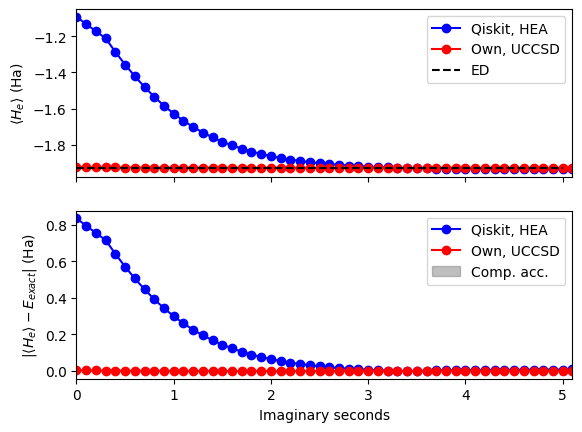

In [18]:
fig, axs = plt.subplots(2,1,sharex=True)
ax = axs[0]
ax2 = axs[1]
#DELTA_BIG = 50
DELTA_BIG = 2
sys = "h2"
e_exact = {"h2": -1.9276748321, "h4": -4.3860854160}

# Readin from file
#with open('h_exp_val.txt', 'r') as f:
#    h_exp_val = [float(num) for line in f for num in line.strip('[] \n').split()]
#with open('times.txt', 'r') as g:
#    times = [float(num) for line in g for num in line.strip('[] \n').split()]

h_exp_val = np.array([ele[0][0].real for ele in result.observables])
times = result.times

ax.plot(times, h_exp_val, '-bo', label= "Qiskit, HEA") #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(avqite_times[::DELTA_BIG], avqite_energies[::DELTA_BIG], '-ro', label= "Own, UCCSD")
ax.plot([e_exact[sys]]*(int(times[-1])+1), '--k', label= "ED")
#ax.axhline(np_result.total_energies, ls='--', 
#           c='k', alpha=0.7, label='Groundstate')
#ax.axhline(np_result.hartree_fock_energy, ls='--', 
#           c='r', alpha=0.7, label="Hartree-Fock")

#pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
ax.set_ylabel(r"$\langle H_e \rangle$ (Ha)")
ax.legend(loc="upper right")
ax.set_xlim([0, times[-1]])
print(f"Final Qiskit electronic energy: {h_exp_val[-1]} Ha")
#print(f"Compare with Qutip ED: -4.3860854160 Ha")
#print(f"Compare with TC-VarQITE for UCCSD: -4.3860791082 Ha")


ax2.plot(times, abs(h_exp_val-e_exact[sys]), "-bo", label= "Qiskit, HEA")
ax2.plot(avqite_times[::DELTA_BIG], abs(avqite_energies-e_exact[sys])[::DELTA_BIG], "-ro", label= "Own, UCCSD")
ax2.fill_between([0,times[-1]],[0,1e-3],color="grey",alpha=0.5,label="Comp. acc.")
ax2.set_xlabel("Imaginary seconds")
ax2.set_ylabel(r"$|\langle H_e \rangle - E_{exact}|$ (Ha)")
ax2.legend(loc="upper right")
ax2.set_xlim([0, times[-1]])